In [60]:
pip install yfinance pandas numpy scipy matplotlib  riskfolio-lib dataframe_image

In [61]:
#Import all the useful libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import riskfolio as rp
import dataframe_image as dfi
from IPython.display import display, Markdown, FileLink

#ignore all the warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format

### Download Data

In [80]:
# Define a disctionary of sectors
#sectors serves as key
# lists of tickers serves as values

sector_tickers = {
    'NIFTY_Commodities': ['RELIANCE.NS', 'ULTRACEMCO.NS', 'TATASTEEL.NS', 'NTPC.NS', 'JSWSTEEL.NS', 'ONGC.NS', 'GRASIM.NS', 'HINDALCO.NS', 'COALINDIA.NS', 'UPL.NS'],
    'NIFTY_Energy': ['RELIANCE.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'TATAPOWER.NS', 'BPCL.NS', 'IOC.NS', 'GAIL.NS', 'ADANIGREEN.NS'],
    'NIFTY_Manufacturing': ['SUNPHARMA.NS', 'RELIANCE.NS', 'M&M.NS', 'TATASTEEL.NS', 'MARUTI.NS', 'JSWSTEEL.NS', 'HINDALCO.NS', 'TATAMOTORS.NS', 'DRREDDY.NS', 'CIPLA.NS'],
    'NIFTY_Services': ['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'BAJFINANCE.NS'],
    'NIFTY_MNC': ['MARUTI.NS', 'HINDUNILVR.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'VEDL.NS', 'SIEMENS.NS', 'AMBUJACEM.NS', 'CUMMINSIND.NS', 'ASHOKLEY.NS'],
    'NIFTY_Transportation': ['M&M.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'ADANIPORTS.NS', 'EICHERMOT.NS', 'BAJAJ-AUTO.NS', 'HEROMOTOCO.NS', 'TIINDIA.NS', 'TVSMOTOR.NS', 'ASHOKLEY.NS'],
    'NIFTY_Infrastructure': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'APOLLOHOSP.NS', 'ADANIPORTS.NS'],
    'NIFTY_Housing': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS'],
    'NIFTY_Consumption': ['ITC.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'M&M.NS', 'MARUTI.NS', 'TITAN.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'DMART.NS'],
    'NIFTY_100_ESG': ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'ICICIBANK.NS', 'BHARTIARTL.NS', 'TECHM.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS', 'TITAN.NS']
}

In [81]:
start = "2018-01-01"
end = "2021-12-31"
trading_days = 250 # This is the annualization factor; we are assuming 250 trading days per year
risk_free_rate = 0

# Prepare data for download
print("Prepare data for download")
rows = []
for sector,tickers in sector_tickers.items():
    for ticker in tickers:
        rows.append({'Assets':ticker, 'Sector': sector})
#print(rows)
#Now we want rows to show in a form of a dataframe/we want to create a dataframe with two columns :Assets and Sectors
sector_df = pd.DataFrame(rows).drop_duplicates() 
#print(sector_df)
# we do not assets that occurs in more than one sector
assets = sector_df['Assets'].unique().tolist() # this is a list of unique assets
#print(assets)

data = yf.download(assets, start = start , end=end, auto_adjust = True, progress = False)['Close']
#check missing values
missing_values = data.isna().sum()
data = data.dropna(axis = 1, how= 'all')
#print(missing_values)
#print(data.head())


Prepare data for download


### Calculate Assets  Daily Returns 

In [82]:
Y_assets = data.pct_change().replace([np.inf, -np.inf], np.inf) # this are daily returns within the lookback period mathematically this is given by :
Y_assets = Y_assets.fillna(method = 'ffill').fillna(method = 'bfill').dropna(axis = 1)
sector_df = sector_df[sector_df['Assets'].isin(Y_assets.columns)] # We want to keep assets that we have returns for in our sector data frame
#print(sector_df)

### Set up the Optimisation problem

In [83]:
port = rp.HCPortfolio(returns = Y_assets) # create an portfolio object/instance of a Portfolio class and pass the historical daily returns to it.
#We need expected returns and the covariance matrix
#method_mu = 'hist' # Initialize the method_mu to hist  to indicate that it will use the historical returns to compute the 
# expected returns / mean returns ( returns.mean()) ; mathematically given by:
#method_cov = 'hist' #Initialise the method_cov to hist to get the covariance matrix of returns using the historical returns ( returns.cov())

#Call a function in the portfolio class called assets_stats 
#port.assets_stats(method_mu='hist', method_cov='hist') # This function computes the expected returns of every asset and stores them in the mu attribute
# it also computes the covariance matrix and stores it in the cov attribute


#print(port.mu) # Expected returns
#print(port.cov) # Covariance matrix

# Hierarchical Risk Parity Optimization
# HRP Optimization
#hcp = rp.HCPortfolio(returns=Y_assets)
w_hrp = port.optimization(
    model='HRP',
    codependence='distance',
    rm='MV',
    rf=risk_free_rate,
    linkage='ward',
    leaf_order=True
).squeeze() #Run the optimization to get the optimal weights
#Opmal weights that maximize the sharpe ratio are allocated to each asset.
#print(w_mvo)


### Normalize the weights and create weights dataframe

In [84]:
w_hrp = w_hrp/ w_hrp.sum() # ensure that the weights sum up to 1
#print(w_mvo)
# create a weight data frame with two columns , Assets and Portfolio weights then merge it with sector data frame so that we can know
#which sector does each asset belong to.
weight_df = pd.DataFrame({'Assets': w_hrp.index,
                         'HRP_weight': w_hrp}).merge(sector_df, on = 'Assets')
#print(weight_df)

### Compute the Marginal contribution to risk

In [85]:
def calculate_mcr(weights, cov_matrix):
    port_var = np.dot(weights.values, np.dot(cov_matrix.values, weights.values))
    port_std = np.sqrt(port_var)
    mcr = np.dot(cov_matrix.values, weights.values) / port_std
    return pd.Series(mcr, index=weights.index)

# Calculate covariance matrix once
cov_matrix = port.cov

# Compute MCR for each portfolio
mcr_hrp = calculate_mcr(w_hrp, cov_matrix)



### Compute the Performance of the portfolio

In [86]:
def calculate_Performance(returns, name):
    annual_returns = returns.mean() * trading_days #average daily returns  (The average of the weighted daily returns times the trading days = 250)
    annual_volatility = returns.std()*np.sqrt(trading_days) #standard deviation of the weighted daily returns
    Sharpe_ratio = (annual_returns - risk_free_rate )/ annual_volatility  # A metric used for risk -adjusted returns
    metrics_performance = {'Portfolio': name,
                          'Annual Return': annual_returns,
                          'Annual Volatility': annual_volatility,
                          'Sharpe Ratio': Sharpe_ratio}
    
    return metrics_performance

performance_data = []
for sector in weight_df['Sector'].unique():
    sector_data = weight_df[weight_df['Sector'] == sector]
    assets = sector_data['Assets'].values
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP_weight'].values, axis =1).sum(axis =1)  #We get the weighted returns
    performance_data.append(calculate_Performance(hrp_returns, f"{sector}(HRP)")) # we use the weighted returns to compute the annual returns
    #print(performance_data)
performance_df = pd.DataFrame(performance_data )
#print(performance_df)

# Add average MCR per sector & portfolio to performance_df
mcr_summary = []
for sector in weight_df['Sector'].unique():
    sector_assets = weight_df[weight_df['Sector'] == sector]['Assets']
    #print(sector_assets)
    avg_mcr_hrp = mcr_rp.loc[sector_assets].mean()
    #print(avg_mcr_mvo)
    mcr_summary.append({
        'Portfolio': f"{sector} (HRP)",
        'Avg Marginal Contribution to Risk': avg_mcr_hrp
    })
    #print(mcr_summary)

mcr_summary_df = pd.DataFrame(mcr_summary)
#print(mcr_summary_df)
#make sure that the naming in both dataframes matches
import re

def normalize_portfolio_name(name):
    # Remove any spaces before parentheses and strip outer spaces
    return re.sub(r'\s*\(', '(', name).strip()

performance_df['Portfolio'] = performance_df['Portfolio'].apply(normalize_portfolio_name)
mcr_summary_df['Portfolio'] = mcr_summary_df['Portfolio'].apply(normalize_portfolio_name)
#
if 'Avg Marginal Contribution to Risk' in performance_df.columns:
    performance_df = performance_df.drop(columns=['Avg Marginal Contribution to Risk'])
#Keep one clean Avg Marginal contribution to risk column
# Now merge without NaNs
performance_df = performance_df.merge(mcr_summary_df, on='Portfolio', how='left')

#print(performance_df)

### Save the Tables

In [87]:
def save_table(df, title, filename):
    formatted_df = df.copy()
    formatted_df['Annual Return'] = formatted_df['Annual Return'].astype(float).map('{:.2%}'.format)
    formatted_df['Annual Volatility'] = formatted_df['Annual Volatility'].astype(float).map('{:.2%}'.format)
    formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].astype(float).map('{:.2f}'.format)
    formatted_df['Avg Marginal Contribution to Risk'] = formatted_df['Avg Marginal Contribution to Risk'].map('{:.6f}'.format)
    styled = (formatted_df.style
              .set_caption(title)
              .set_properties(**{'text-align': 'center'}))
    dfi.export(styled, f'{filename}.png', table_conversion='matplotlib')
    df.to_excel(f'{filename}.xlsx', float_format="%.6f")
    return styled

### Sector weights table

In [88]:
def generate_sector_tables(weights_df):
    unique_weights = weights_df.drop_duplicates(subset='Assets')
    for sector in weights_df['Sector'].unique():
        sector_assets = weights_df[weights_df['Sector'] == sector]['Assets'].unique()
        sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

        # Calculate total weights for each mvo portfolio
        sector_hrp_weight = sector_data['HRP_weight'].sum()
        

        # Create normalized weights
        sector_data = sector_data.copy() # create a deep copy
        sector_data['HRP_weight (Normalized)'] = sector_data['HRP_weight'] / sector_hrp_weight
        

        display(Markdown(f"### {sector} Sector Weights"))
        display(sector_data[['Assets', 'HRP_weight (Normalized)']]
                .style.format({
                    'HRP_weight (Normalized)': '{:.4f}'
                }))

### Compute cumulative returns for the portfolio 

In [89]:
# SECTOR CUMULATIVE RETURNS PLOTS
def plot_sector_cumulative_returns(sector_name):
    sector_data = weight_df[weight_df['Sector'] == sector_name]
    assets = sector_data['Assets'].values

    # Calculate returns for the mvo strategy
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP_weight'].values, axis=1).sum(axis=1) # sum of all the weighted daily returns within the lookback period

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    ((1 + hrp_returns).cumprod()-1).plot(label='HRP') # 1 is just the initial capital( 100% of the initial investor wealth)
    
    plt.title(f'{sector_name} - Cumulative Returns')
    plt.ylabel('Cumulative returns')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{sector_name}_cumulative_returns.png', bbox_inches='tight')
    plt.show()

### Sector Visualization

In [90]:
def plot_sector_visualizations(sector_name):
    unique_weights = weight_df.drop_duplicates(subset='Assets')
    sector_assets = weight_df[weight_df['Sector'] == sector_name]['Assets'].unique()
    sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

    # Calculate total weights
    sector_hrp_weight = sector_data['HRP_weight'].sum()
    
    # Create normalized weights
    sector_data['HRP_weight Normalized'] = sector_data['HRP_weight'] / sector_hrp_weight
    # Create figure with 3 subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))

    # HRP Pie Chart
    sector_data.set_index('Assets')['HRP_weight Normalized'].plot.pie(
        ax=ax1, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title(f'HRP Allocation\nTotal: {sector_hrp_weight:.1%}')
    plt.suptitle(f'Sector: {sector_name}', y=1.05)
    plt.tight_layout()
    plt.savefig(f'{sector_name}_pie_charts.png', bbox_inches='tight')
    plt.show()



### Main function Execution

# Sector Weight Tables

### NIFTY_Energy Sector Weights

### NIFTY_Transportation Sector Weights

### NIFTY_Infrastructure Sector Weights

### NIFTY_MNC Sector Weights

### NIFTY_Consumption Sector Weights

### NIFTY_Services Sector Weights

### NIFTY_100_ESG Sector Weights

### NIFTY_Housing Sector Weights

### NIFTY_Manufacturing Sector Weights

### NIFTY_Commodities Sector Weights

# Portfolio Performance Metrics

C:\Users\godis\Downloads\sector_performance.xlsx

# Sector Allocations

## NIFTY_Energy

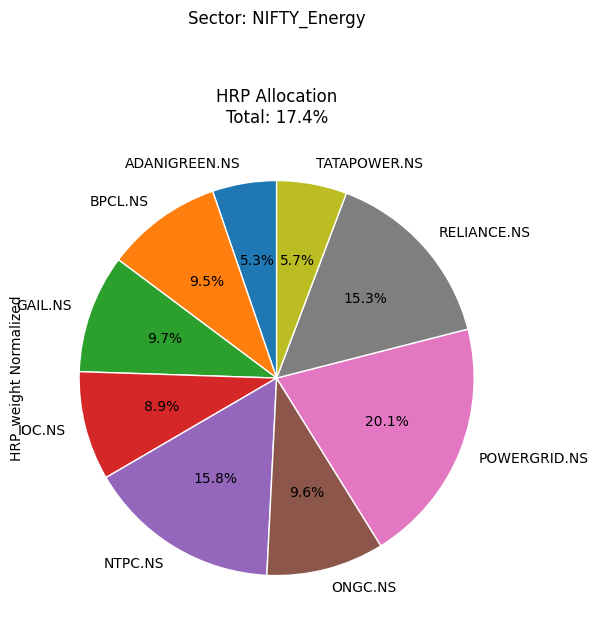

## NIFTY_Transportation

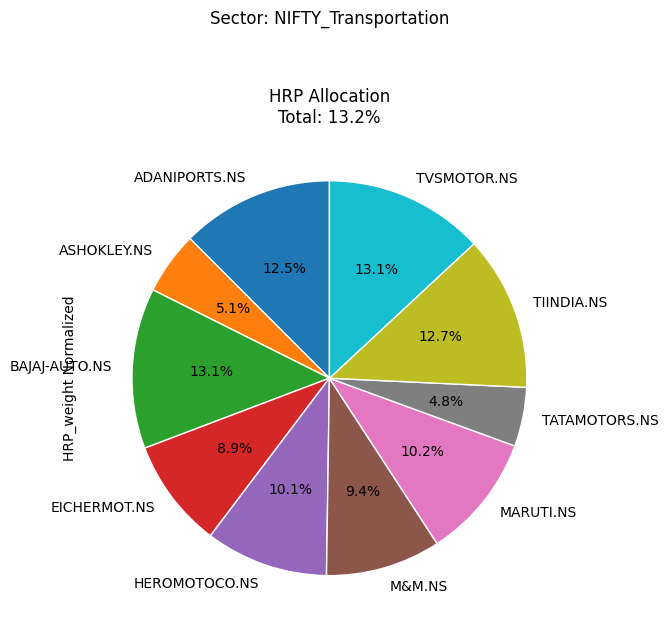

## NIFTY_Infrastructure

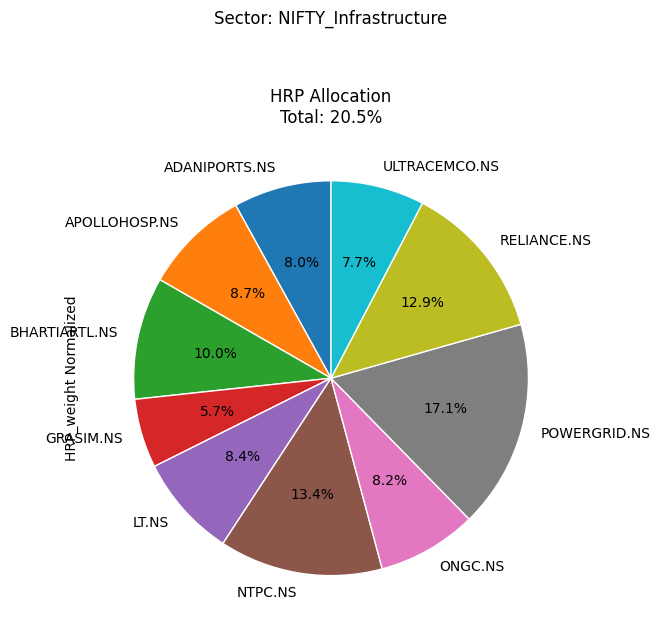

## NIFTY_MNC

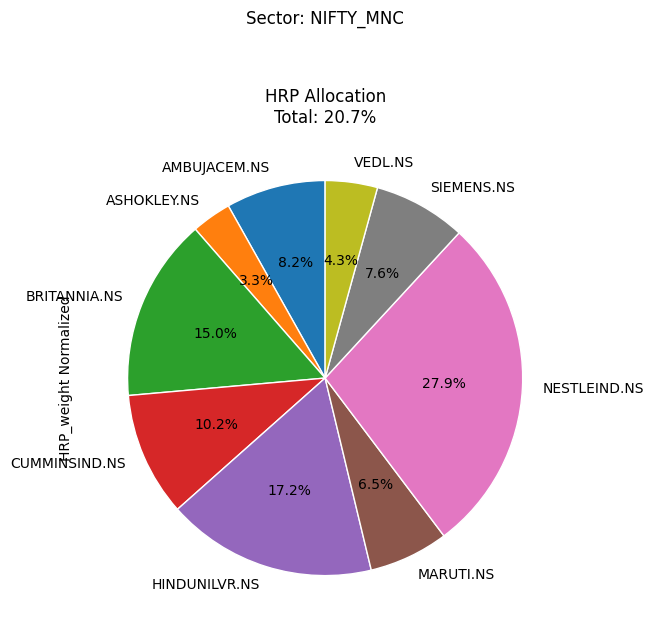

## NIFTY_Consumption

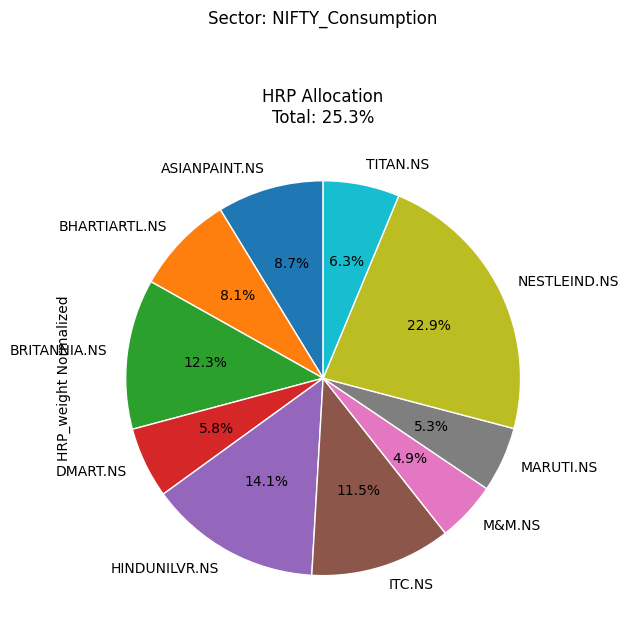

## NIFTY_Services

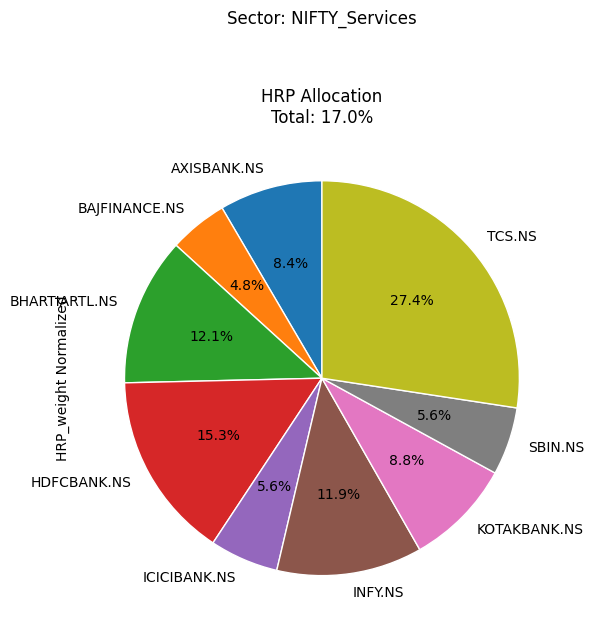

## NIFTY_100_ESG

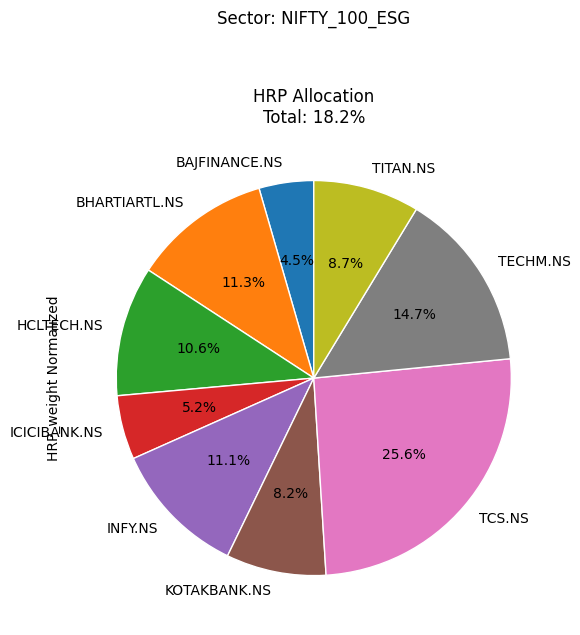

## NIFTY_Housing

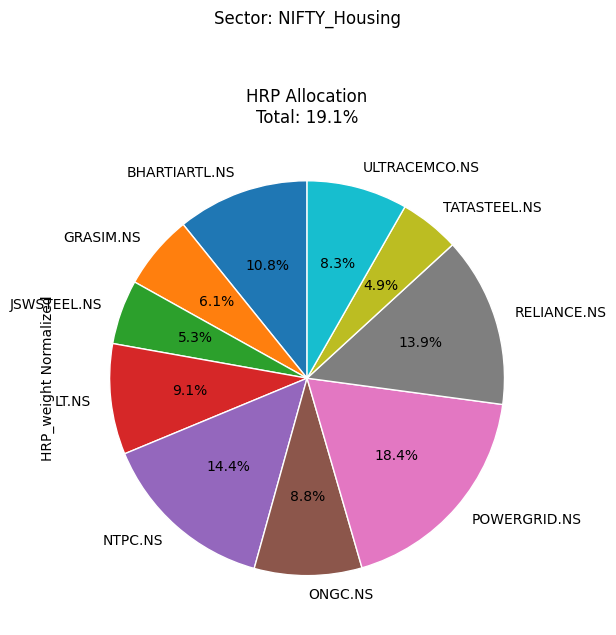

## NIFTY_Manufacturing

## NIFTY_Commodities

# Sector Cumulative Returns

## NIFTY_Energy

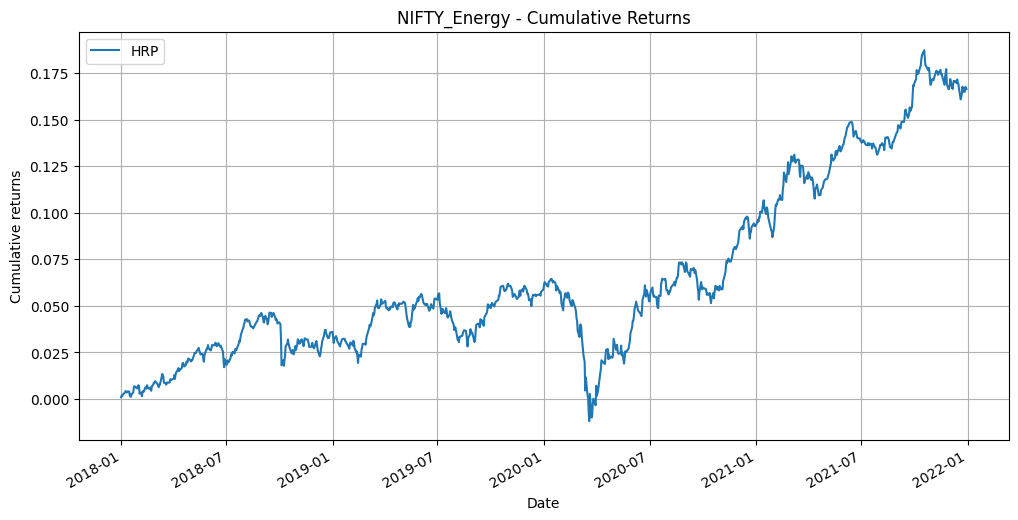

## NIFTY_Transportation

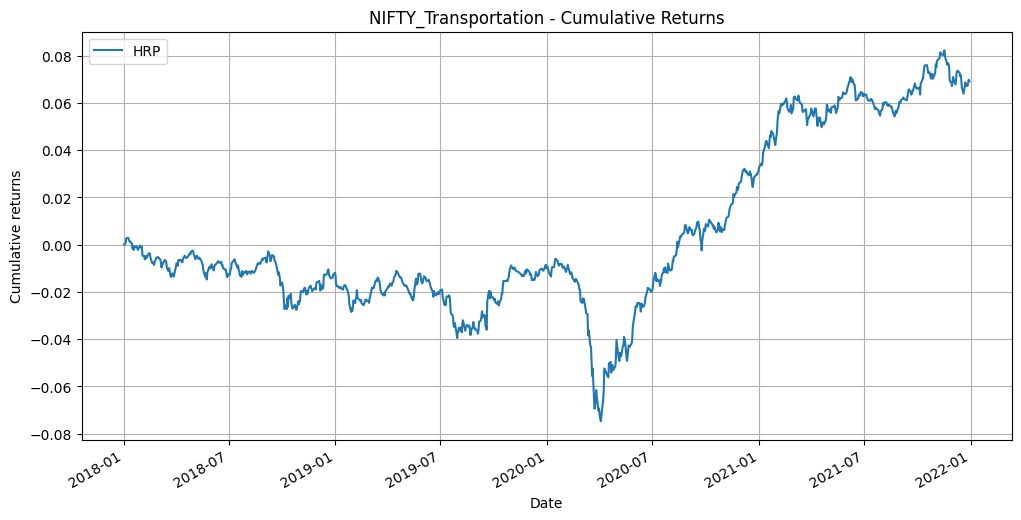

## NIFTY_Infrastructure

## NIFTY_MNC

## NIFTY_Consumption

## NIFTY_Services

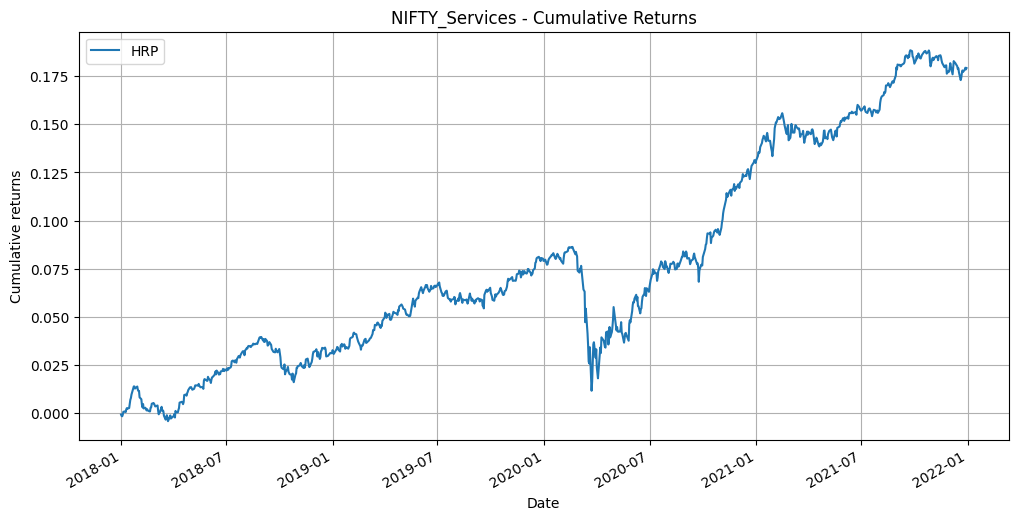

## NIFTY_100_ESG

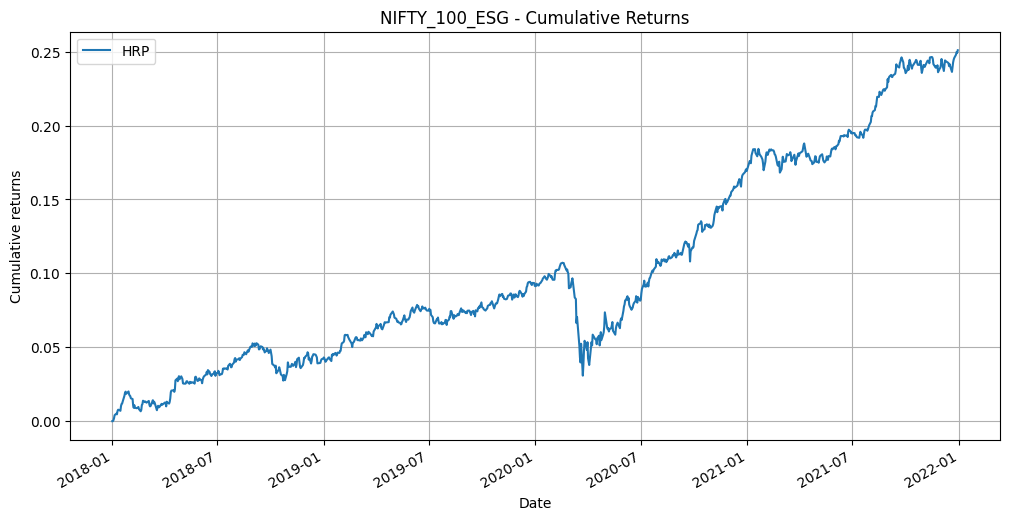

## NIFTY_Housing

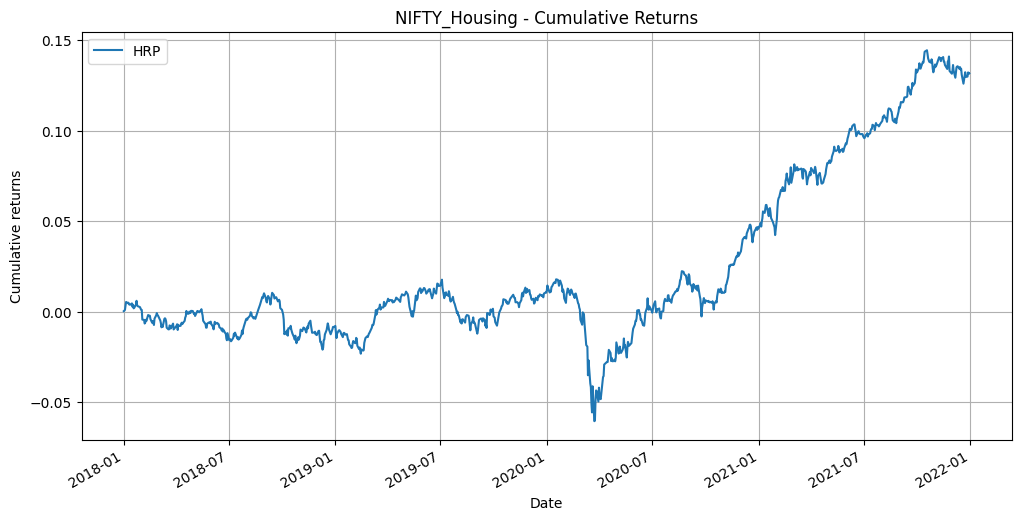

## NIFTY_Manufacturing

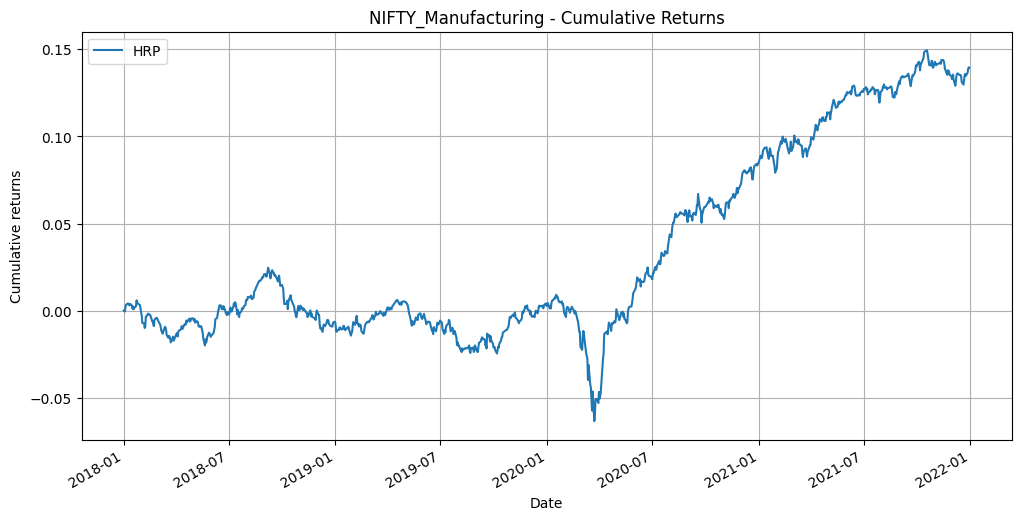

## NIFTY_Commodities

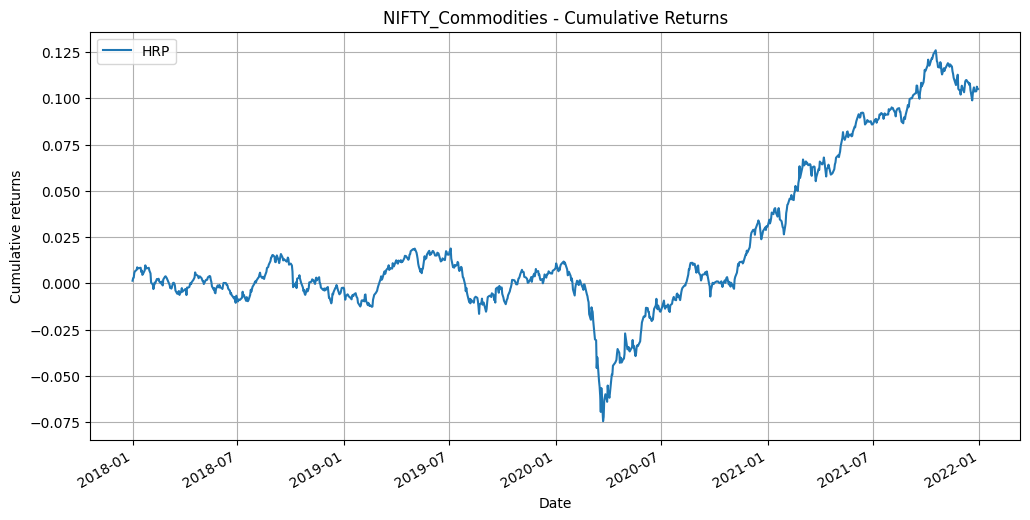

# Overall Portfolio Performance

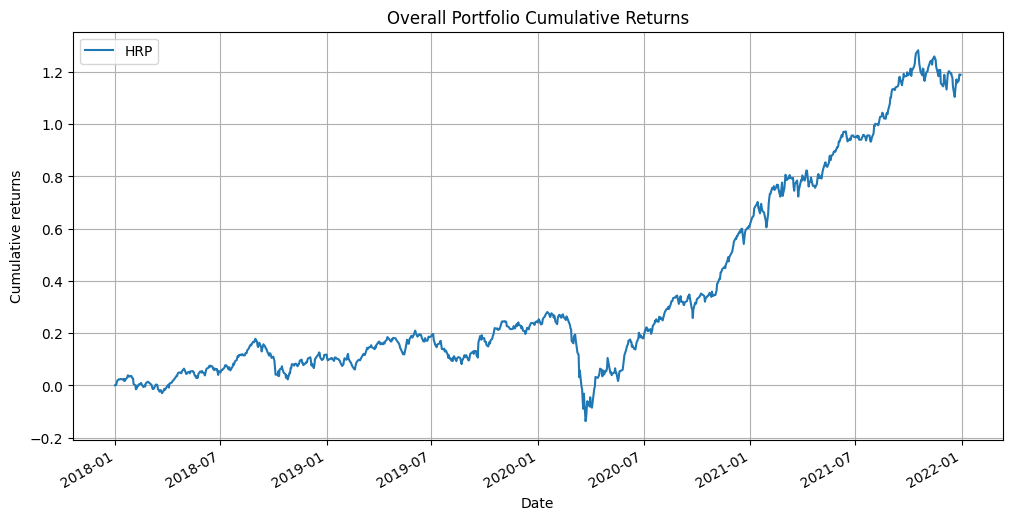

In [91]:
display(Markdown("# Sector Weight Tables"))
generate_sector_tables(weight_df)

display(Markdown("# Portfolio Performance Metrics"))
performance_styled = save_table(performance_df, 'Portfolio Performance by Sector', 'sector_performance')
display(performance_styled)
display(FileLink('sector_performance.xlsx', result_html_prefix="Download Excel Table: "))

display(Markdown("# Sector Allocations"))
for sector in weight_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_visualizations(sector)

display(Markdown("# Sector Cumulative Returns"))
for sector in weight_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_cumulative_returns(sector)

display(Markdown("# Overall Portfolio Performance"))
plt.figure(figsize=(12, 6))
((1 + (Y_assets @ w_hrp)).cumprod()-1).plot(label='HRP')
plt.title('Overall Portfolio Cumulative Returns')
plt.ylabel('Cumulative returns')
plt.legend()
plt.grid(True)
plt.savefig('overall_cumulative_returns.png', bbox_inches='tight')
plt.show()


Preparing data...
Running portfolio optimization...


# Sector Weight Tables

### NIFTY_Energy Sector Weights

### NIFTY_Transportation Sector Weights

### NIFTY_Infrastructure Sector Weights

### NIFTY_MNC Sector Weights

### NIFTY_Consumption Sector Weights

### NIFTY_Services Sector Weights

### NIFTY_100_ESG Sector Weights

### NIFTY_Housing Sector Weights

### NIFTY_Manufacturing Sector Weights

### NIFTY_Commodities Sector Weights

# Portfolio Performance Metrics

C:\Users\godis\Downloads\sector_performance.xlsx

# Sector Allocations

## NIFTY_Energy

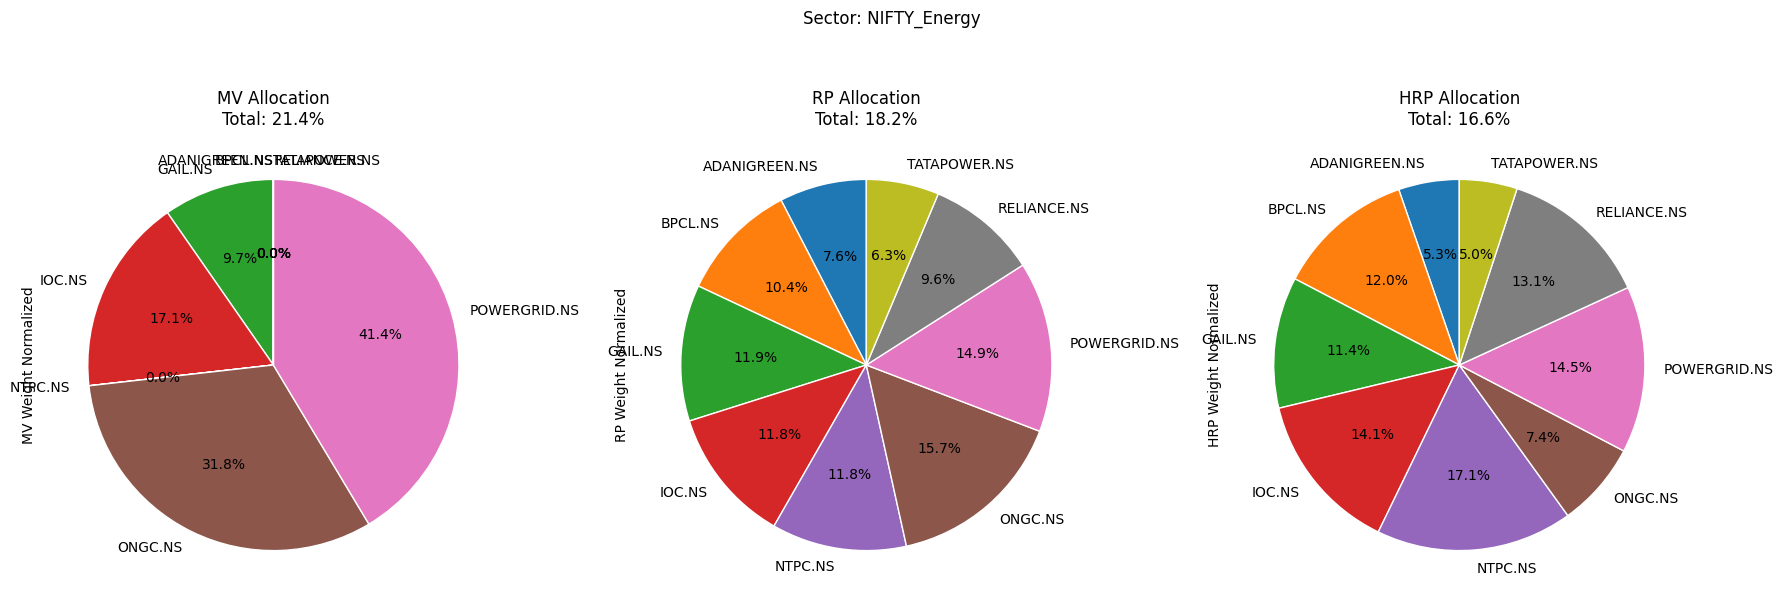

## NIFTY_Transportation

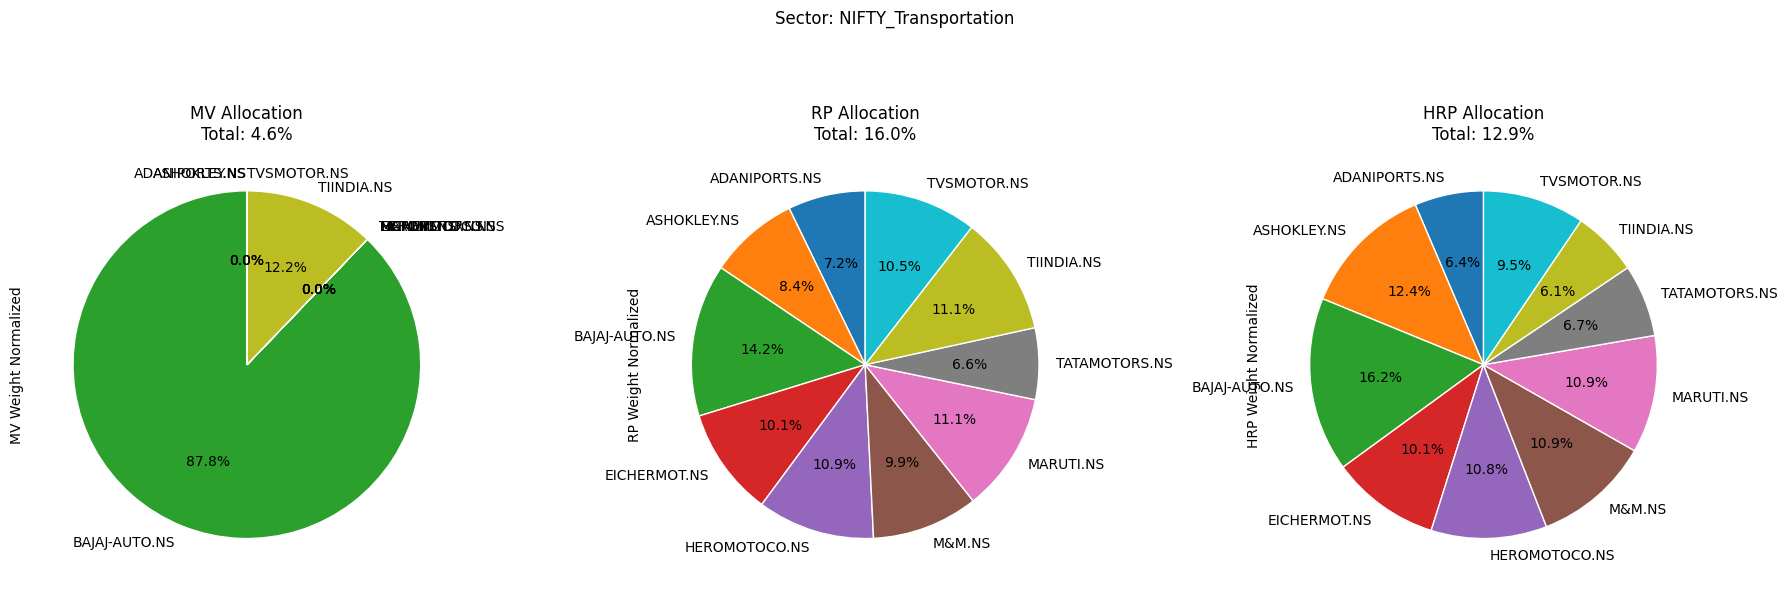

## NIFTY_Infrastructure

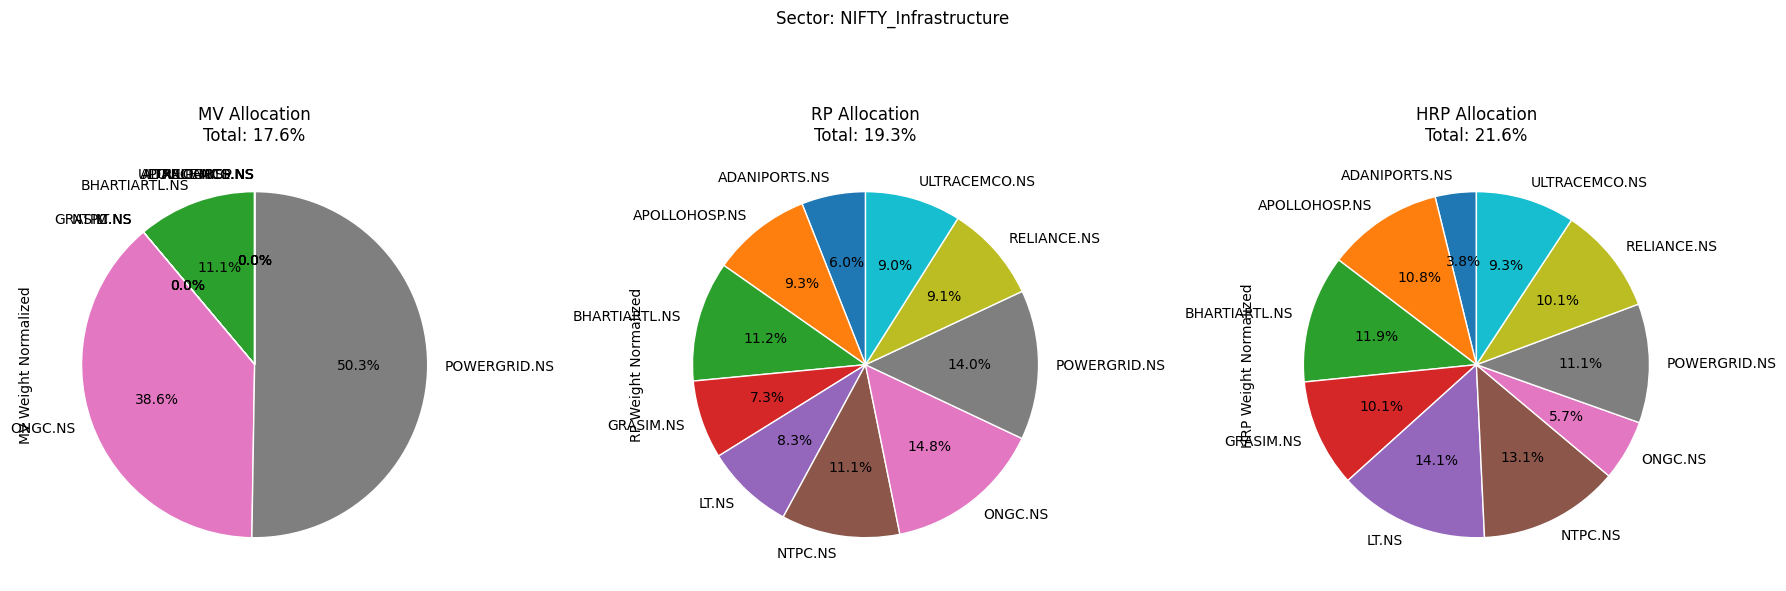

## NIFTY_MNC

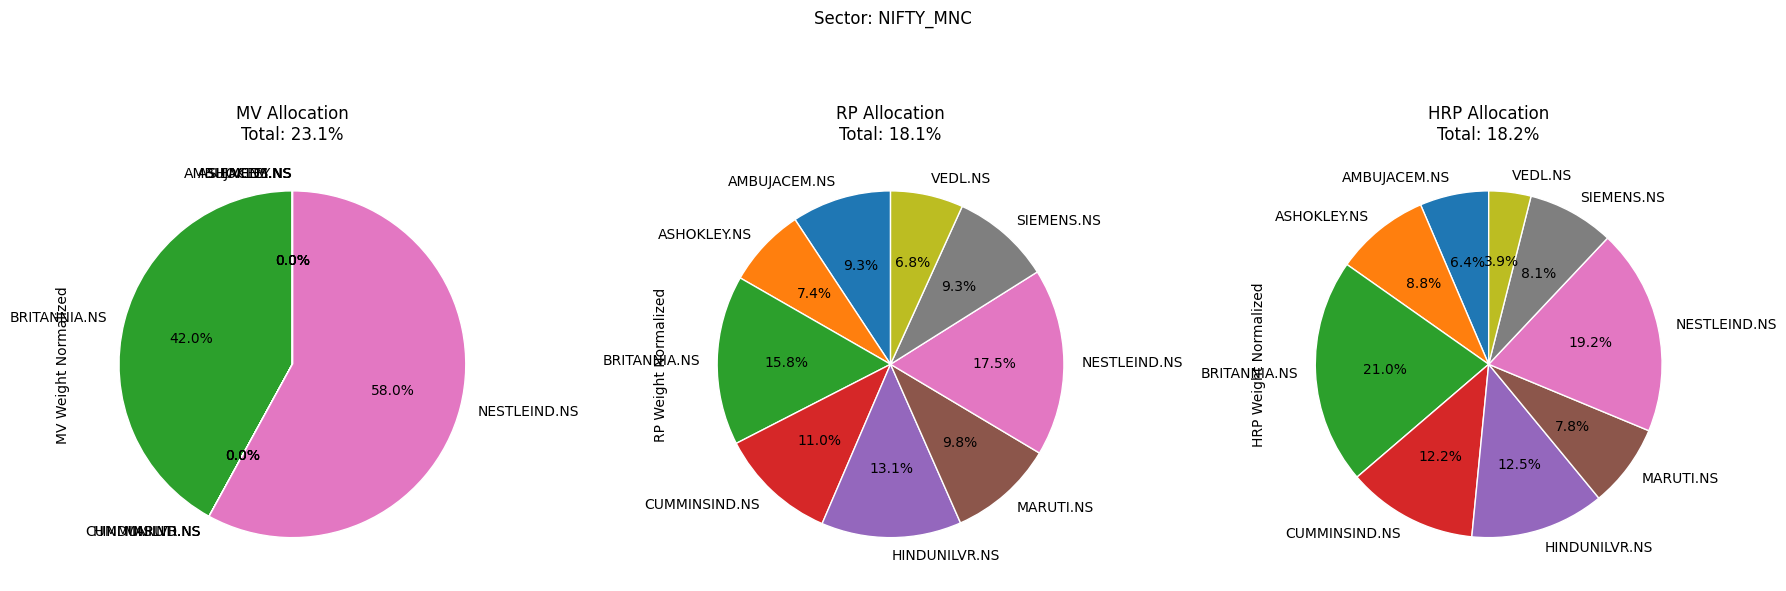

## NIFTY_Consumption

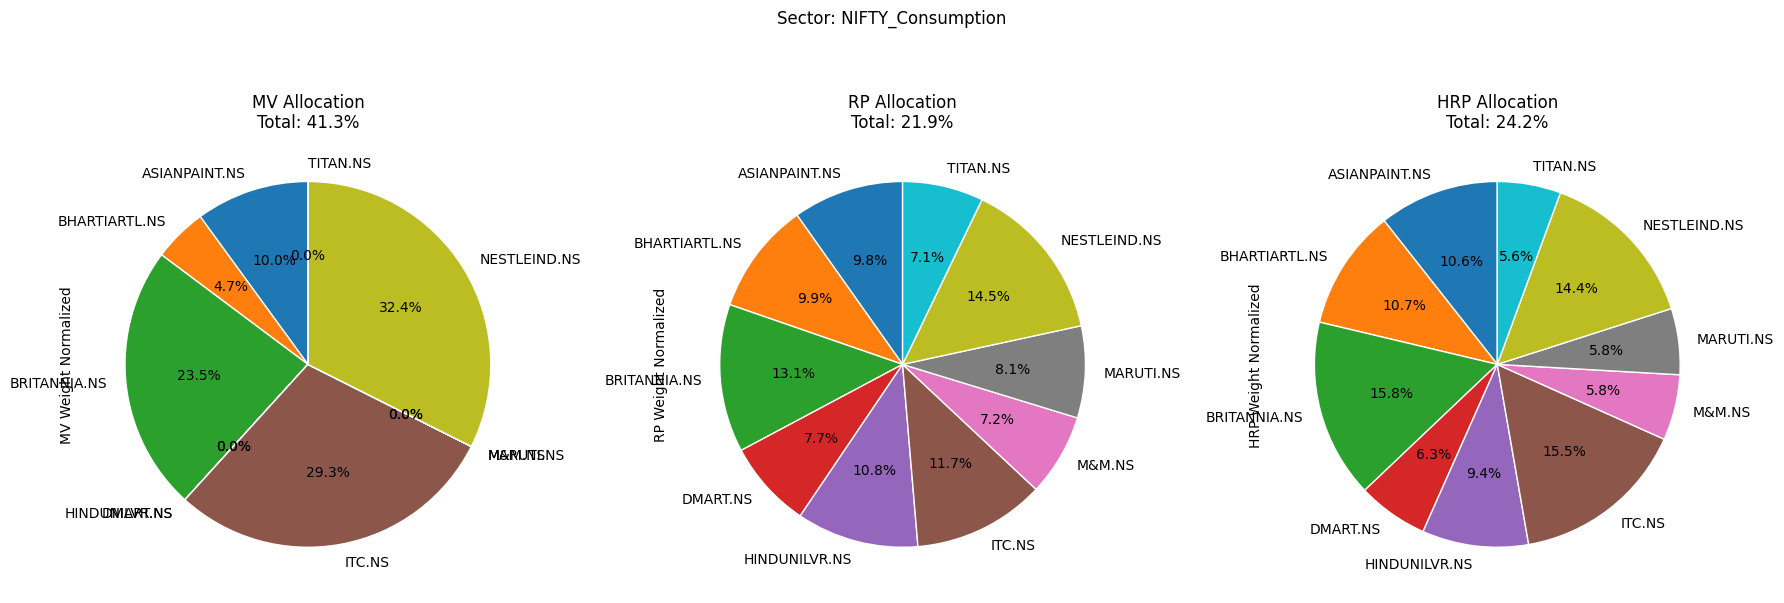

## NIFTY_Services

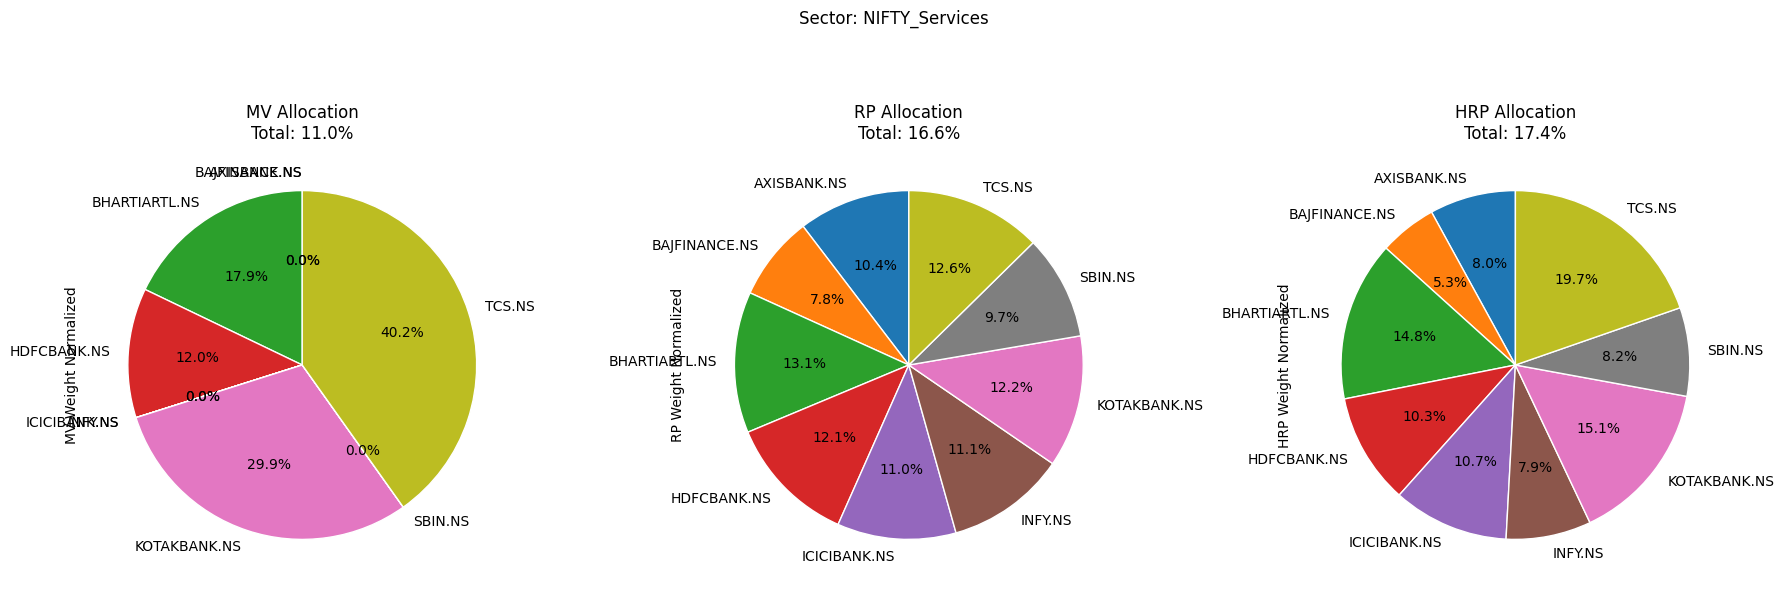

## NIFTY_100_ESG

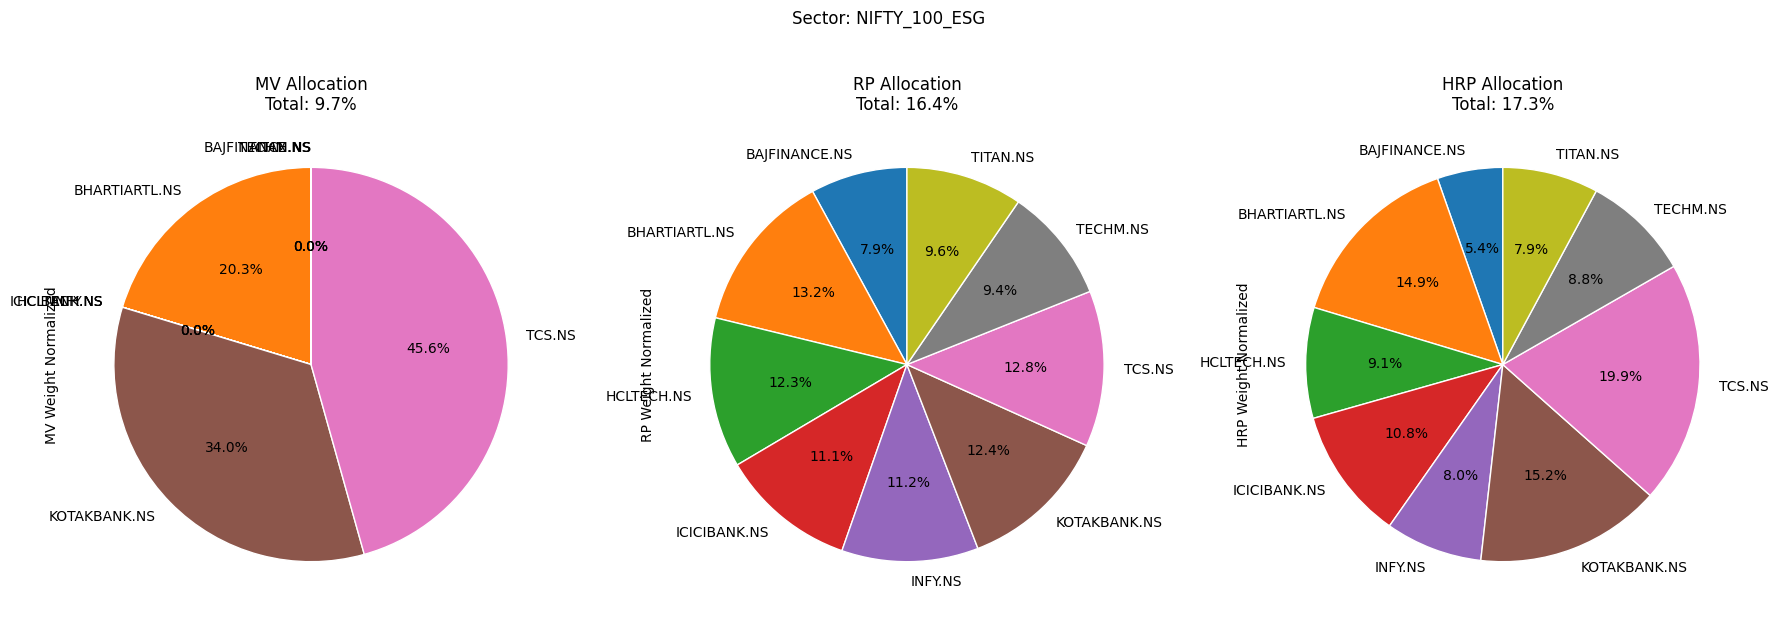

## NIFTY_Housing

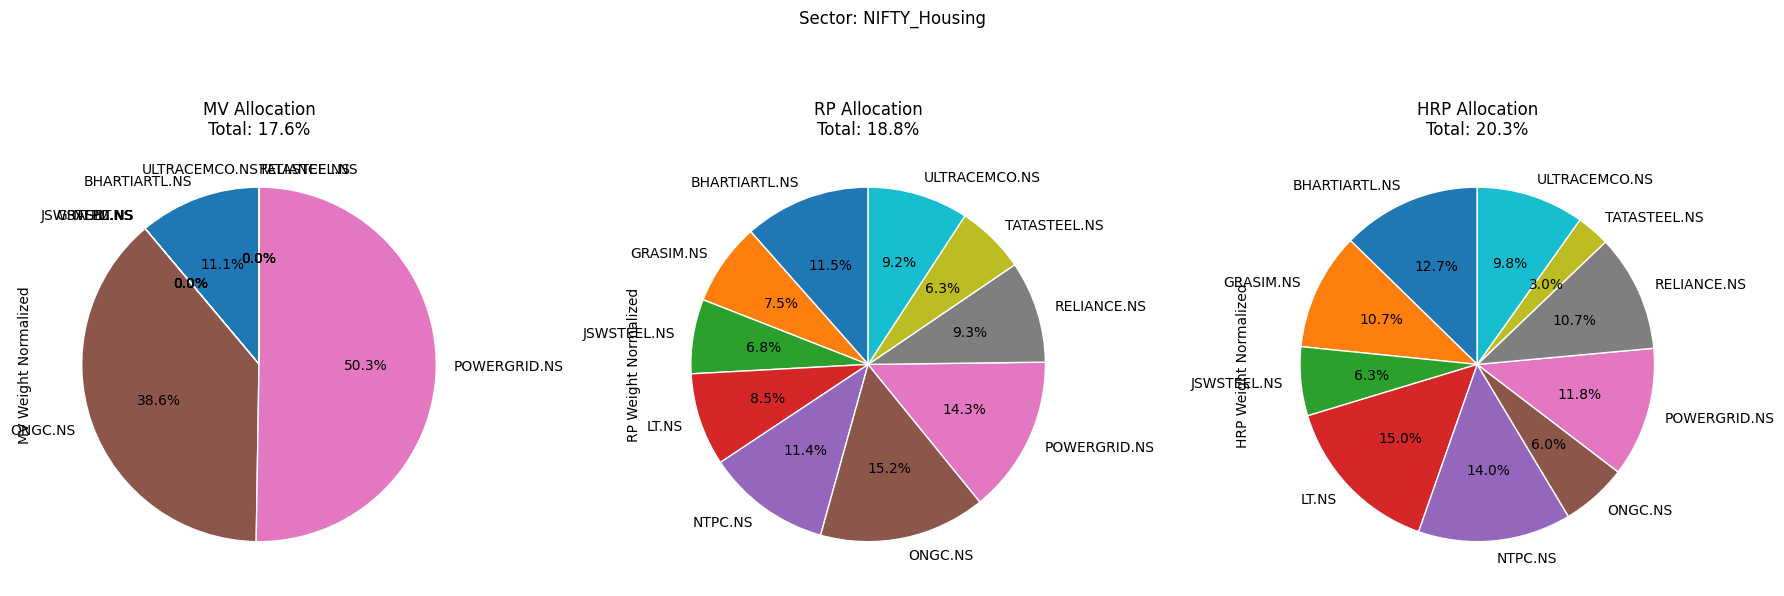

## NIFTY_Manufacturing

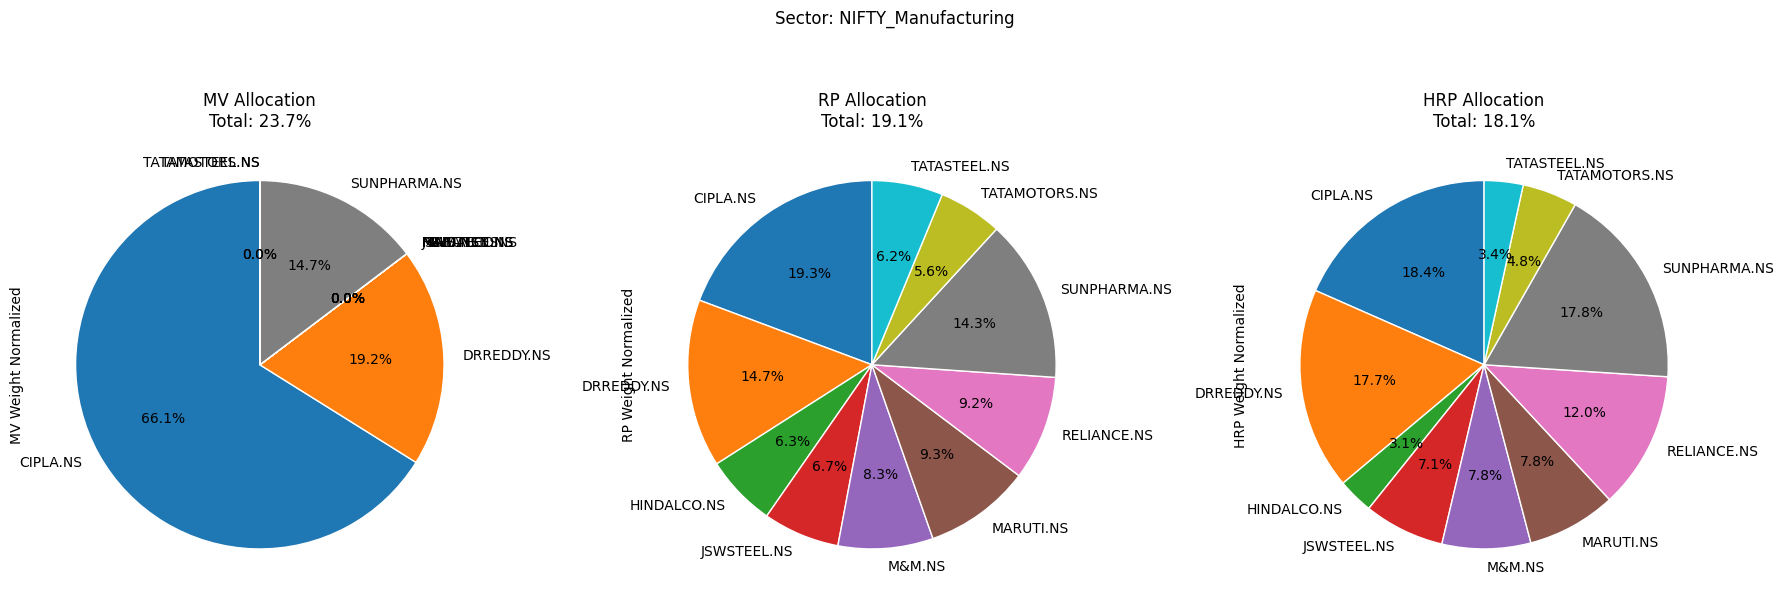

## NIFTY_Commodities

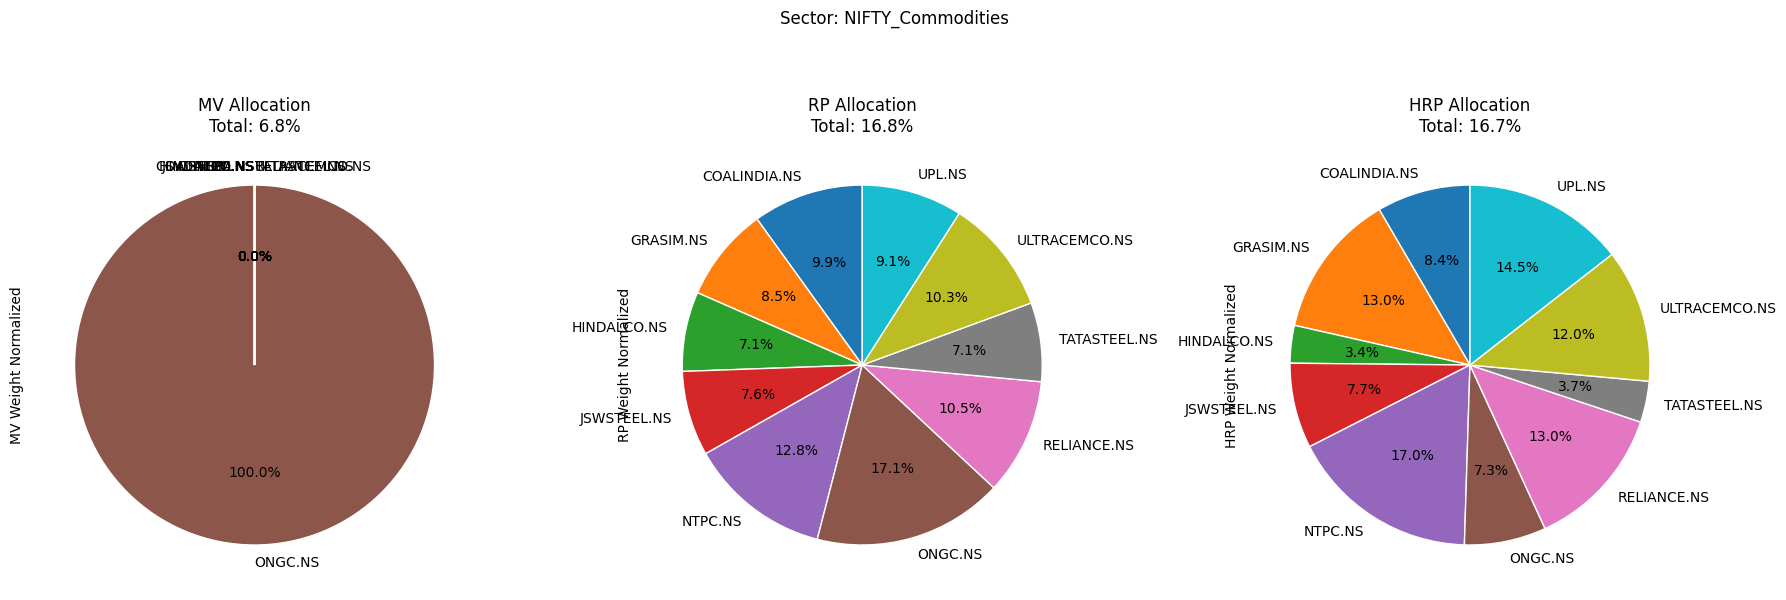

# Sector Cumulative Returns

## NIFTY_Energy

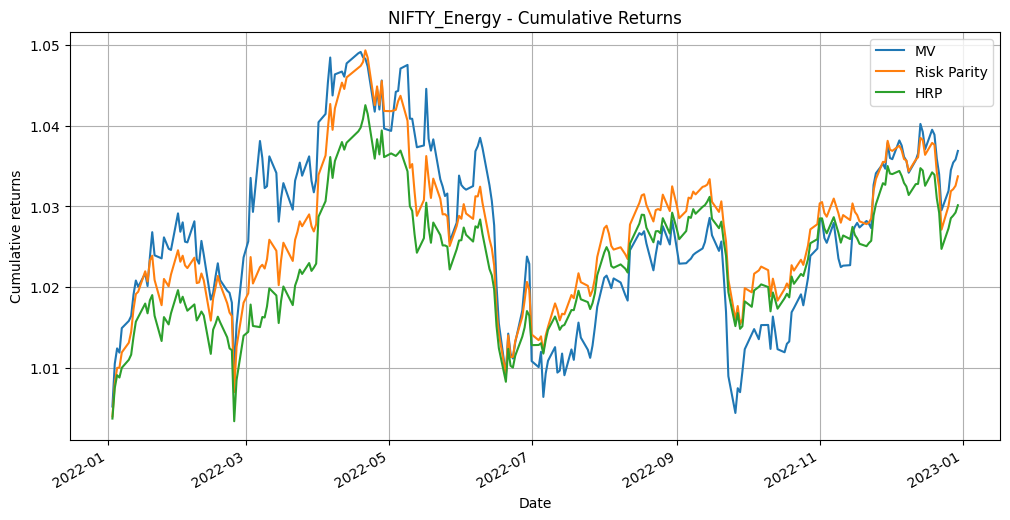

## NIFTY_Transportation

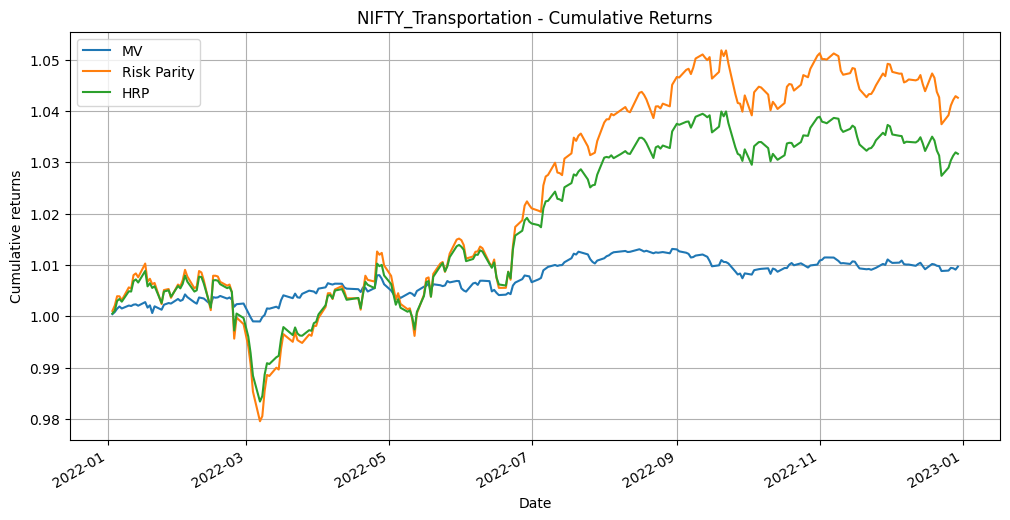

## NIFTY_Infrastructure

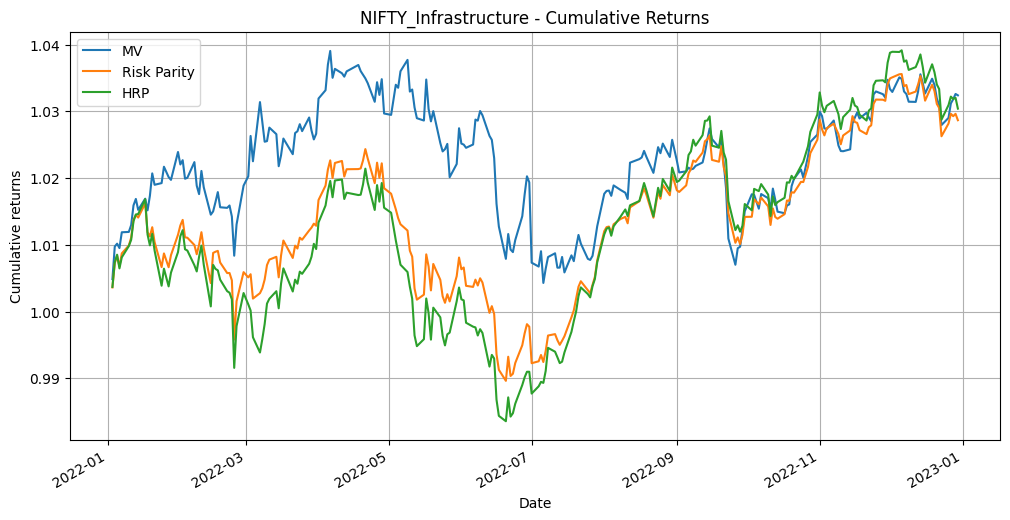

## NIFTY_MNC

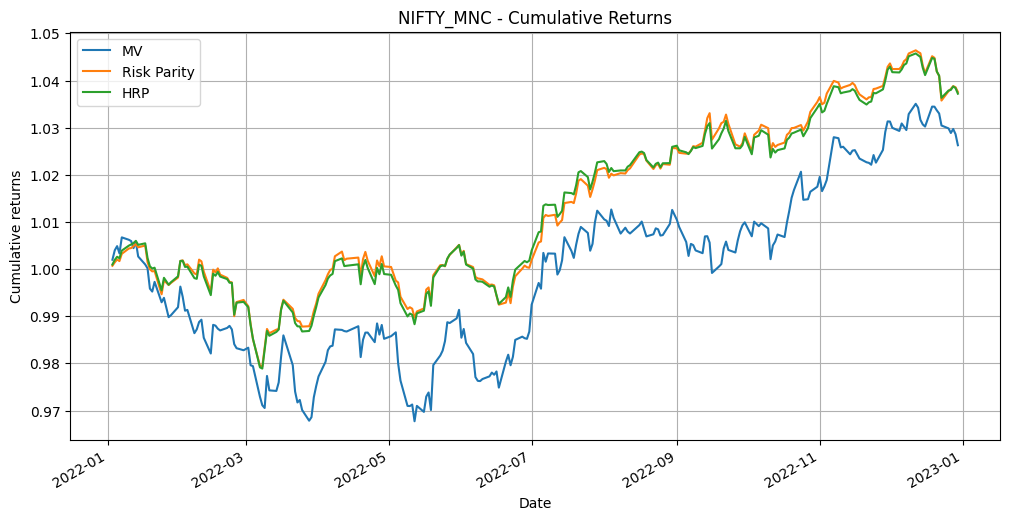

## NIFTY_Consumption

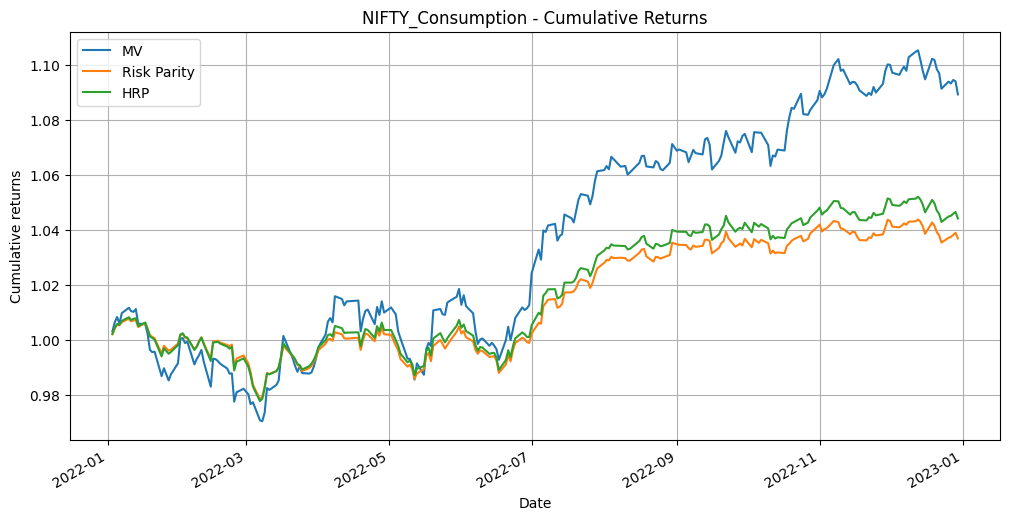

## NIFTY_Services

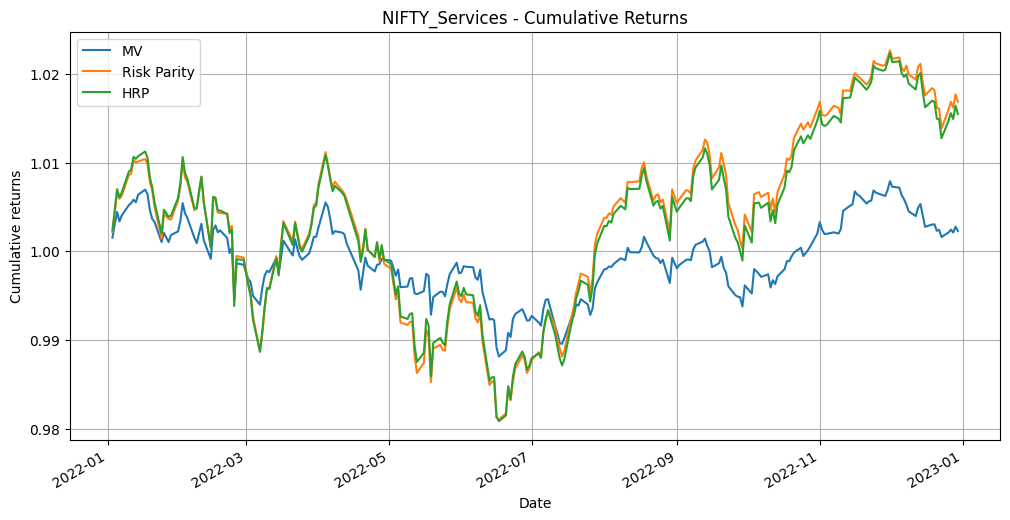

## NIFTY_100_ESG

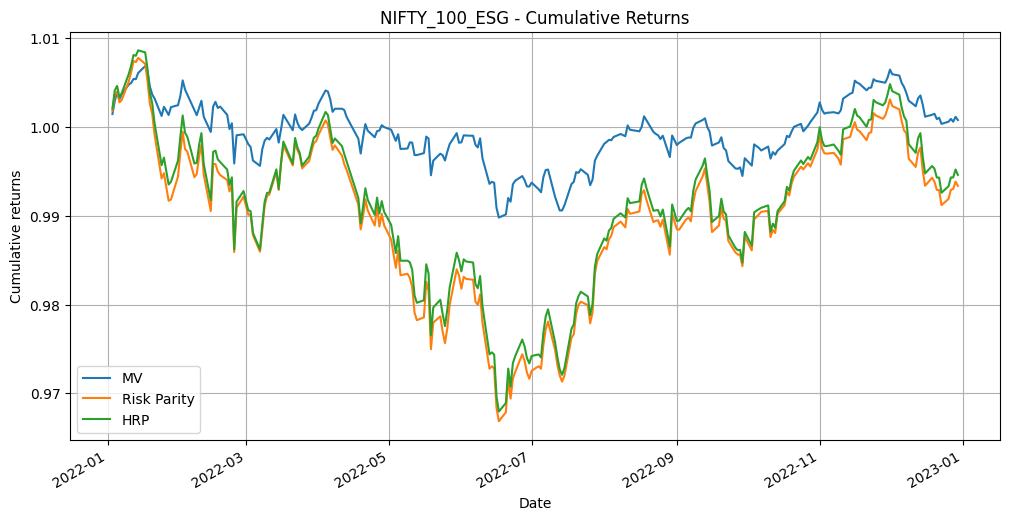

## NIFTY_Housing

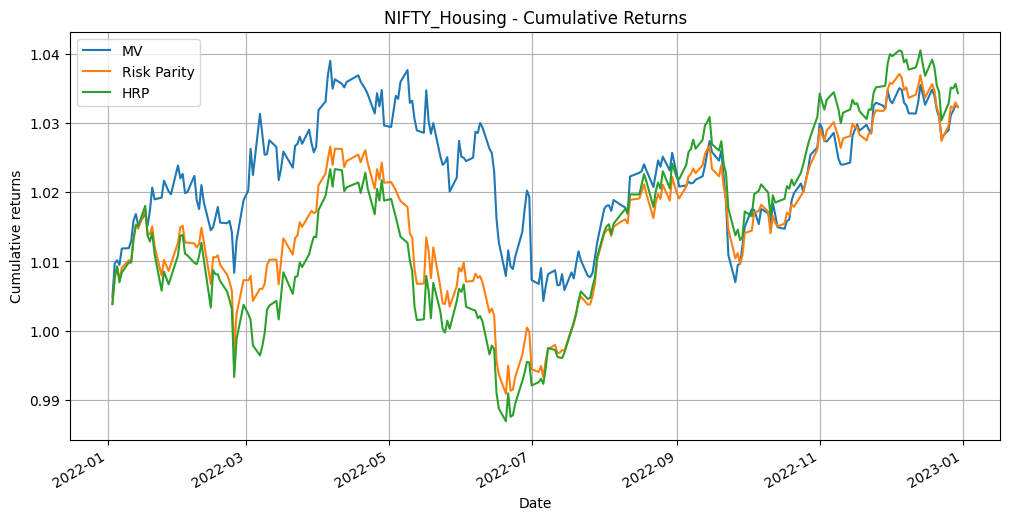

## NIFTY_Manufacturing

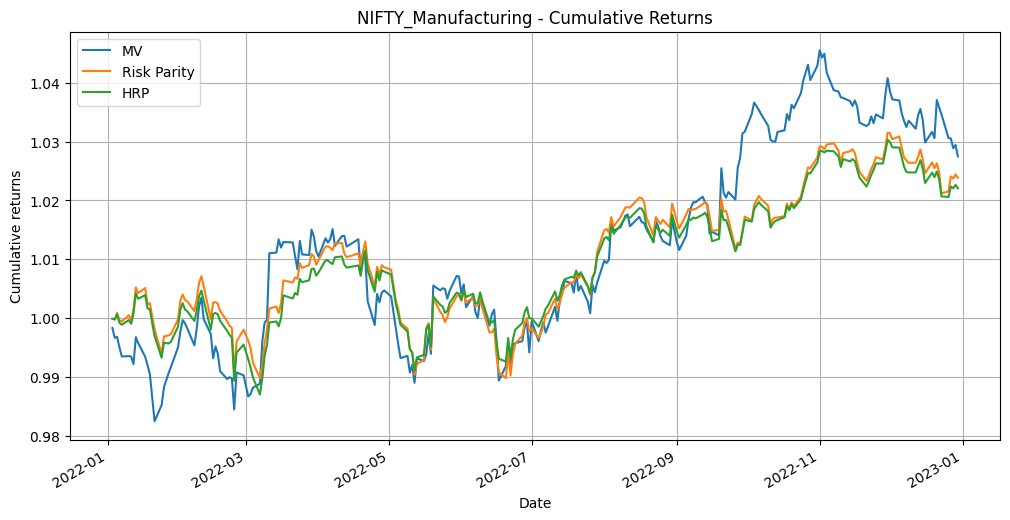

## NIFTY_Commodities

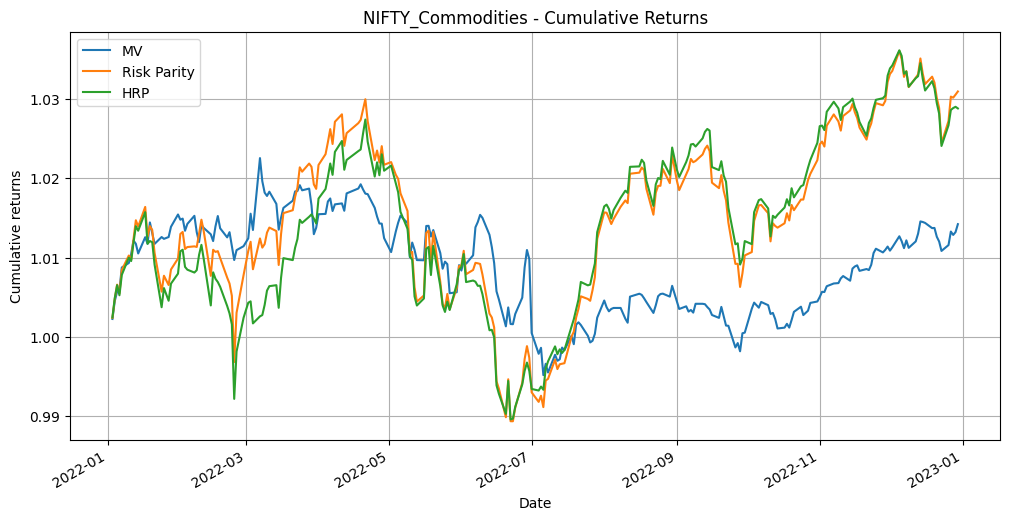

# Overall Portfolio Performance

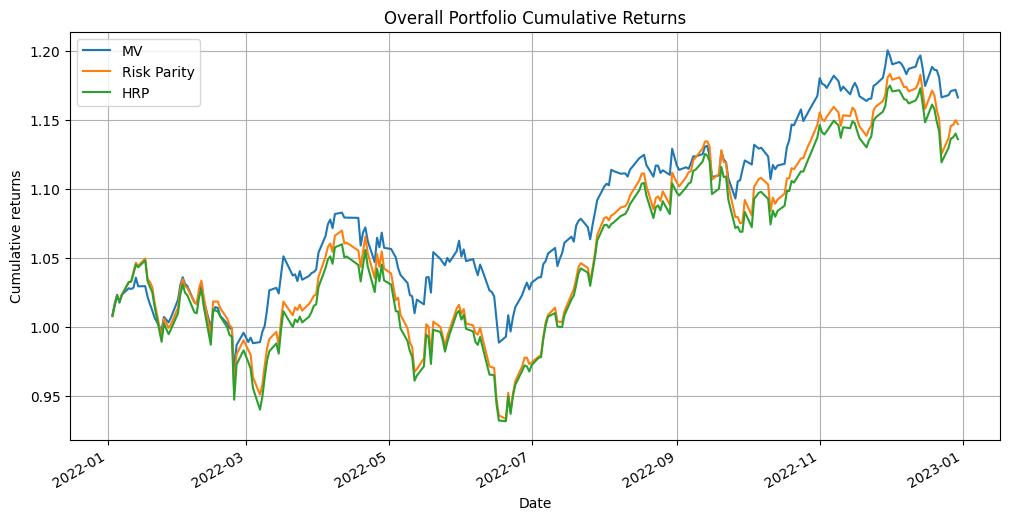

Analysis complete!


In [74]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import dataframe_image as dfi
from IPython.display import display, Markdown, FileLink

# Suppress warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format

# PARAMETERS
start = '2022-01-01'
end = '2022-12-31'
trading_days = 250
rf = 0

# SECTOR DEFINITIONS
sector_tickers = {
    'NIFTY_Commodities': ['RELIANCE.NS', 'ULTRACEMCO.NS', 'TATASTEEL.NS', 'NTPC.NS', 'JSWSTEEL.NS', 'ONGC.NS', 'GRASIM.NS', 'HINDALCO.NS', 'COALINDIA.NS', 'UPL.NS'],
    'NIFTY_Energy': ['RELIANCE.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'TATAPOWER.NS', 'BPCL.NS', 'IOC.NS', 'GAIL.NS', 'ADANIGREEN.NS'],
    'NIFTY_Manufacturing': ['SUNPHARMA.NS', 'RELIANCE.NS', 'M&M.NS', 'TATASTEEL.NS', 'MARUTI.NS', 'JSWSTEEL.NS', 'HINDALCO.NS', 'TATAMOTORS.NS', 'DRREDDY.NS', 'CIPLA.NS'],
    'NIFTY_Services': ['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'BAJFINANCE.NS'],
    'NIFTY_MNC': ['MARUTI.NS', 'HINDUNILVR.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'VEDL.NS', 'SIEMENS.NS', 'AMBUJACEM.NS', 'CUMMINSIND.NS', 'ASHOKLEY.NS'],
    'NIFTY_Transportation': ['M&M.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'ADANIPORTS.NS', 'EICHERMOT.NS', 'BAJAJ-AUTO.NS', 'HEROMOTOCO.NS', 'TIINDIA.NS', 'TVSMOTOR.NS', 'ASHOKLEY.NS'],
    'NIFTY_Infrastructure': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'APOLLOHOSP.NS', 'ADANIPORTS.NS'],
    'NIFTY_Housing': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS'],
    'NIFTY_Consumption': ['ITC.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'M&M.NS', 'MARUTI.NS', 'TITAN.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'DMART.NS'],
    'NIFTY_100_ESG': ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'ICICIBANK.NS', 'BHARTIARTL.NS', 'TECHM.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS', 'TITAN.NS']
}

# DATA PREPARATION
print("Preparing data...")
rows = []
for sector, tickers in sector_tickers.items():
    for ticker in tickers:
        rows.append({'Assets': ticker, 'Sector': sector})
sector_df = pd.DataFrame(rows).drop_duplicates()
#invalid_tickers = ['ADANITRANS.NS', 'MCDOWELL-N.NS', 'HDFC.NS']
#sector_df = sector_df[~sector_df['Assets'].isin(invalid_tickers)]
assets = sector_df['Assets'].unique().tolist()
assets.sort()
print(f"Downloading data for {len(assets)} stocks...")
data = yf.download(assets, start=start, end=end, auto_adjust=True, progress=False)['Close']
data = data.dropna(axis=1, how='all')
Y_assets = data.pct_change().replace([np.inf, -np.inf], np.nan)
Y_assets = Y_assets.fillna(method='ffill').fillna(method='bfill').dropna(axis=1)
sector_df = sector_df[sector_df['Assets'].isin(Y_assets.columns)]

# PORTFOLIO OPTIMIZATION
print("Running portfolio optimization...")
port = rp.Portfolio(returns=Y_assets)
port.assets_stats(method_mu='hist', method_cov='hist')

# MVO Optimization
w_mvo = port.optimization(model='Classic', rm='MV', obj='MinRisk', rf=rf, hist=True).squeeze()

# Risk Parity Optimization
w_rp = port.rp_optimization(model='Classic', rm='MV', rf=rf, hist=True).squeeze()

# HRP Optimization
hcp = rp.HCPortfolio(returns=Y_assets)
w_hrp = hcp.optimization(
    model='HRP',
    codependence='distance',
    rm='MV',
    rf=rf,
    linkage='ward',
    leaf_order=True
).squeeze()

# Normalize weights
w_mvo = w_mvo / w_mvo.sum()
w_rp = w_rp / w_rp.sum()
w_hrp = w_hrp / w_hrp.sum()

weights_df = pd.DataFrame({
    'Assets': w_mvo.index,
    'MV Weight': w_mvo,
    'RP Weight': w_rp,
    'HRP Weight': w_hrp
}).merge(sector_df, on='Assets')

# === Marginal Contribution to Risk (MCR) Calculation Function ===
def calculate_mcr(weights, cov_matrix):
    port_var = np.dot(weights.values, np.dot(cov_matrix.values, weights.values))
    port_std = np.sqrt(port_var)
    mcr = np.dot(cov_matrix.values, weights.values) / port_std
    return pd.Series(mcr, index=weights.index)

# Calculate covariance matrix once
cov_matrix = port.cov

# Compute MCR for each portfolio
mcr_mvo = calculate_mcr(w_mvo, cov_matrix)
mcr_rp = calculate_mcr(w_rp, cov_matrix)
mcr_hrp = calculate_mcr(w_hrp, cov_matrix)

# PERFORMANCE CALCULATION
def calculate_performance(returns, name, trading_days=250, rf=0):
    ann_ret = returns.mean() * trading_days
    ann_vol = returns.std() * np.sqrt(trading_days)
    sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
    return {
        'Portfolio': name,
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe
    }

performance_data = []
for sector in weights_df['Sector'].unique():
    sector_data = weights_df[weights_df['Sector'] == sector]
    assets = sector_data['Assets'].values
    mvo_returns = Y_assets[assets].multiply(sector_data['MV Weight'].values, axis=1).sum(axis=1)
    rp_returns = Y_assets[assets].multiply(sector_data['RP Weight'].values, axis=1).sum(axis=1)
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP Weight'].values, axis=1).sum(axis=1)
    performance_data.append(calculate_performance(mvo_returns, f"{sector} (MV)", rf=rf))
    performance_data.append(calculate_performance(rp_returns, f"{sector} (RP)", rf=rf))
    performance_data.append(calculate_performance(hrp_returns, f"{sector} (HRP)", rf=rf))
performance_df = pd.DataFrame(performance_data)

# Add average MCR per sector & portfolio to performance_df
mcr_summary = []
for sector in weights_df['Sector'].unique():
    sector_assets = weights_df[weights_df['Sector'] == sector]['Assets']
    avg_mcr_mvo = mcr_mvo.loc[sector_assets].mean()
    avg_mcr_rp = mcr_rp.loc[sector_assets].mean()
    avg_mcr_hrp = mcr_hrp.loc[sector_assets].mean()
    mcr_summary.append({
        'Portfolio': f"{sector} (MV)",
        'Avg Marginal Contribution to Risk': avg_mcr_mvo
    })
    mcr_summary.append({
        'Portfolio': f"{sector} (RP)",
        'Avg Marginal Contribution to Risk': avg_mcr_rp
    })
    mcr_summary.append({
        'Portfolio': f"{sector} (HRP)",
        'Avg Marginal Contribution to Risk': avg_mcr_hrp
    })

mcr_summary_df = pd.DataFrame(mcr_summary)

# Merge MCR summary into performance_df
performance_df = performance_df.merge(mcr_summary_df, on='Portfolio')

# TABLE GENERATION
def save_table(df, title, filename):
    formatted_df = df.copy()
    formatted_df['Annual Return'] = formatted_df['Annual Return'].map('{:.2%}'.format)
    formatted_df['Annual Volatility'] = formatted_df['Annual Volatility'].map('{:.2%}'.format)
    formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].map('{:.2f}'.format)
    formatted_df['Avg Marginal Contribution to Risk'] = formatted_df['Avg Marginal Contribution to Risk'].map('{:.6f}'.format)
    styled = (formatted_df.style
              .set_caption(title)
              .set_properties(**{'text-align': 'center'}))
    dfi.export(styled, f'{filename}.png', table_conversion='matplotlib')
    df.to_excel(f'{filename}.xlsx', float_format="%.6f")
    return styled

# SECTOR WEIGHT TABLES
def generate_sector_tables(weights_df):
    unique_weights = weights_df.drop_duplicates(subset='Assets')
    for sector in weights_df['Sector'].unique():
        sector_assets = weights_df[weights_df['Sector'] == sector]['Assets'].unique()
        sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

        # Calculate total weights for each method
        sector_mvo_weight = sector_data['MV Weight'].sum()
        sector_rp_weight = sector_data['RP Weight'].sum()
        sector_hrp_weight = sector_data['HRP Weight'].sum()

        # Create normalized weights
        sector_data = sector_data.copy()
        sector_data['MV Weight (Normalized)'] = sector_data['MV Weight'] / sector_mvo_weight
        sector_data['RP Weight (Normalized)'] = sector_data['RP Weight'] / sector_rp_weight
        sector_data['HRP Weight (Normalized)'] = sector_data['HRP Weight'] / sector_hrp_weight

        display(Markdown(f"### {sector} Sector Weights"))
        display(sector_data[['Assets', 'MV Weight (Normalized)', 'RP Weight (Normalized)', 'HRP Weight (Normalized)']]
                .style.format({
                    'MV Weight (Normalized)': '{:.4f}',
                    'RP Weight (Normalized)': '{:.4f}',
                    'HRP Weight (Normalized)': '{:.4f}'
                }))

# SECTOR CUMULATIVE RETURNS PLOTS
def plot_sector_cumulative_returns(sector_name):
    sector_data = weights_df[weights_df['Sector'] == sector_name]
    assets = sector_data['Assets'].values

    # Calculate returns for each strategy
    mvo_returns = Y_assets[assets].multiply(sector_data['MV Weight'].values, axis=1).sum(axis=1)
    rp_returns = Y_assets[assets].multiply(sector_data['RP Weight'].values, axis=1).sum(axis=1)
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP Weight'].values, axis=1).sum(axis=1)

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    (1 + mvo_returns).cumprod().plot(label='MV')
    (1 + rp_returns).cumprod().plot(label='Risk Parity')
    (1 + hrp_returns).cumprod().plot(label='HRP')
    plt.title(f'{sector_name} - Cumulative Returns')
    plt.ylabel('Cumulative returns')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{sector_name}_cumulative_returns.png', bbox_inches='tight')
    plt.show()

# SECTOR ALLOCATION VISUALIZATION
def plot_sector_visualizations(sector_name):
    unique_weights = weights_df.drop_duplicates(subset='Assets')
    sector_assets = weights_df[weights_df['Sector'] == sector_name]['Assets'].unique()
    sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

    # Calculate total weights
    sector_mvo_weight = sector_data['MV Weight'].sum()
    sector_rp_weight = sector_data['RP Weight'].sum()
    sector_hrp_weight = sector_data['HRP Weight'].sum()

    # Create normalized weights
    sector_data['MV Weight Normalized'] = sector_data['MV Weight'] / sector_mvo_weight
    sector_data['RP Weight Normalized'] = sector_data['RP Weight'] / sector_rp_weight
    sector_data['HRP Weight Normalized'] = sector_data['HRP Weight'] / sector_hrp_weight

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # MVO Pie Chart
    sector_data.set_index('Assets')['MV Weight Normalized'].plot.pie(
        ax=ax1, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title(f'MV Allocation\nTotal: {sector_mvo_weight:.1%}')

    # RP Pie Chart
    sector_data.set_index('Assets')['RP Weight Normalized'].plot.pie(
        ax=ax2, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax2.set_title(f'RP Allocation\nTotal: {sector_rp_weight:.1%}')

    # HRP Pie Chart
    sector_data.set_index('Assets')['HRP Weight Normalized'].plot.pie(
        ax=ax3, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax3.set_title(f'HRP Allocation\nTotal: {sector_hrp_weight:.1%}')

    plt.suptitle(f'Sector: {sector_name}', y=1.05)
    plt.tight_layout()
    plt.savefig(f'{sector_name}_pie_charts.png', bbox_inches='tight')
    plt.show()

# MAIN EXECUTION
display(Markdown("# Sector Weight Tables"))
generate_sector_tables(weights_df)

display(Markdown("# Portfolio Performance Metrics"))
performance_styled = save_table(performance_df, 'Portfolio Performance by Sector', 'sector_performance')
display(performance_styled)
display(FileLink('sector_performance.xlsx', result_html_prefix="Download Excel Table: "))

display(Markdown("# Sector Allocations"))
for sector in weights_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_visualizations(sector)

display(Markdown("# Sector Cumulative Returns"))
for sector in weights_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_cumulative_returns(sector)

display(Markdown("# Overall Portfolio Performance"))
plt.figure(figsize=(12, 6))
(1 + (Y_assets @ w_mvo)).cumprod().plot(label='MV')
(1 + (Y_assets @ w_rp)).cumprod().plot(label='Risk Parity')
(1 + (Y_assets @ w_hrp)).cumprod().plot(label='HRP')
plt.title('Overall Portfolio Cumulative Returns')
plt.ylabel('Cumulative returns')
plt.legend()
plt.grid(True)
plt.savefig('overall_cumulative_returns.png', bbox_inches='tight')
plt.show()

print("Analysis complete!")
